In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import scanpy as sc 
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os, sys 
sys.path.append('../../src')

/ihome/djishnu/alw399/.local/lib/python3.9/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [4]:
# import celloracle as co

In [5]:
# adata = sc.read_h5ad('/Users/koush/Desktop/training_data/snrna_human_tonsil.h5ad')
adata = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/snrna_human_tonsil.h5ad')
adata

AnnData object with n_obs × n_vars = 5778 × 3333
    obs: 'cell_type', 'author_cell_type', 'cell_type_int', 'banksy_celltypes', 'cell_type_2'
    uns: 'cell_thresholds', 'cell_type_int_colors', 'received_ligands', 'received_ligands_tfl'
    obsm: 'spatial', 'spatial_unscaled'
    layers: 'imputed_count', 'normalized_count'

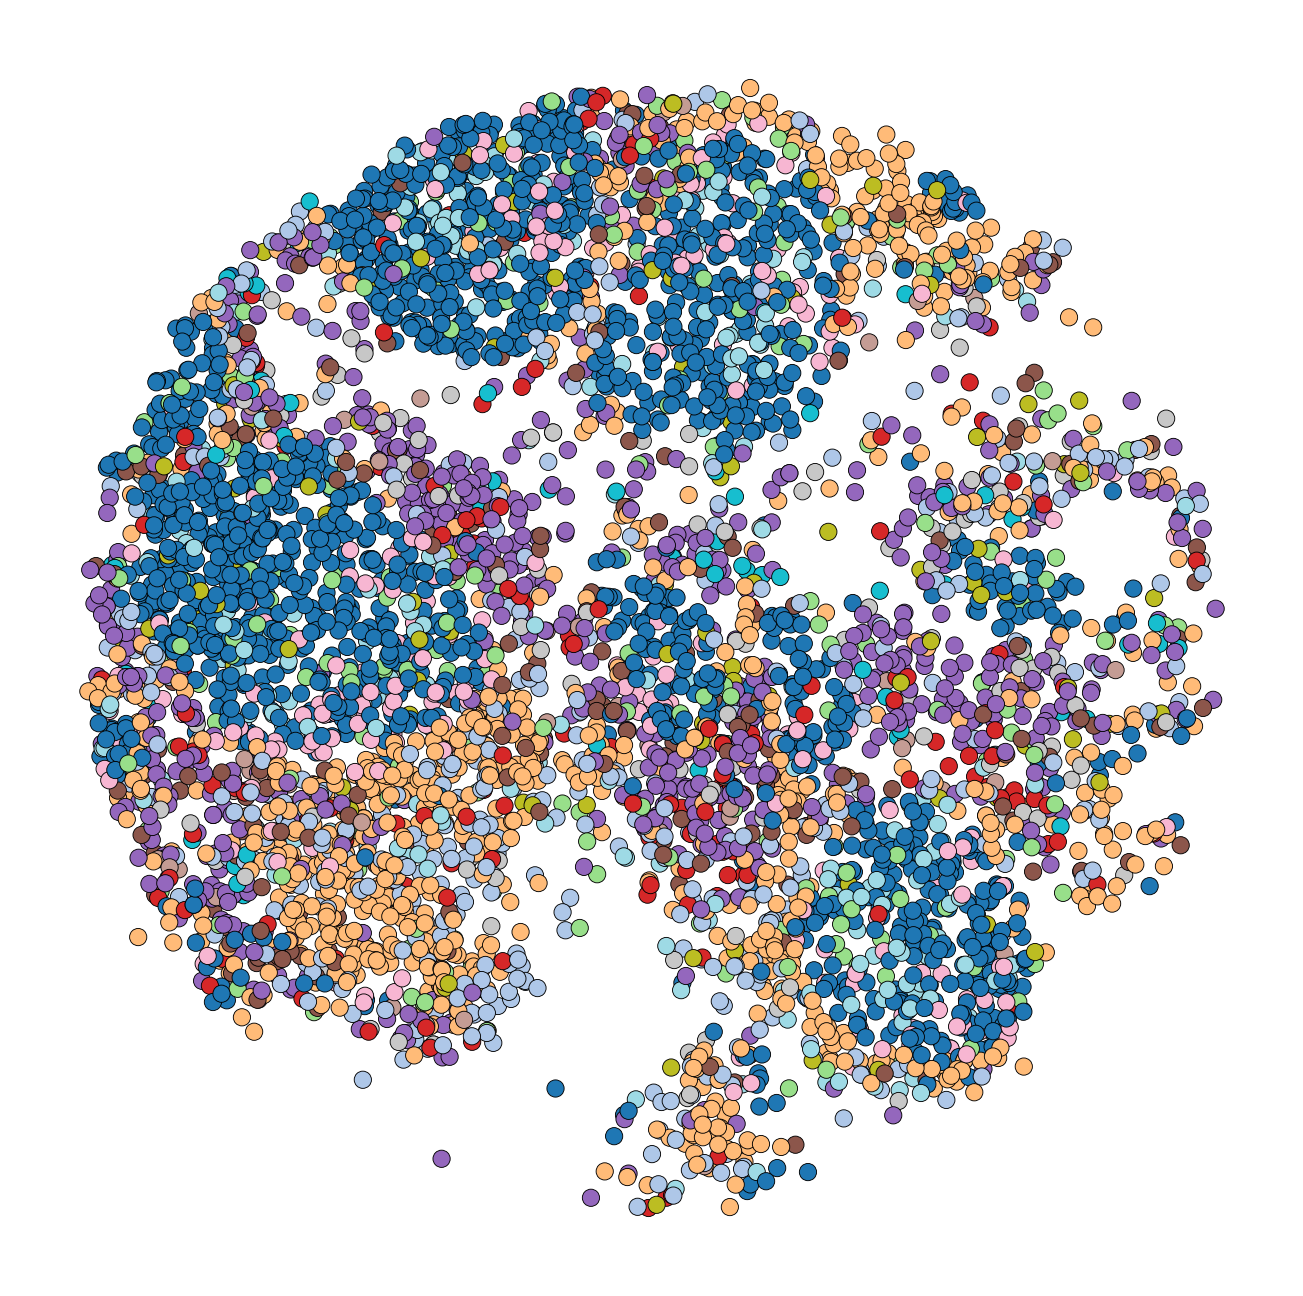

In [6]:
plt.rcParams['figure.figsize'] = [5, 5]
plt.rcParams['figure.dpi'] = 160
sc.pl.embedding(adata, basis='spatial', 
    color='cell_type', frameon=False, title='', 
    legend_loc=None, size=60, add_outline=False, palette='tab20', 
    outline_width=(0.2, 0.1), linewidth=0.2, edgecolor='black')

In [7]:
from spaceoracle.prophets import Prophet
from spaceoracle.plotting.cartography import xy_from_adata
from spaceoracle.plotting.cartography import Cartography
from spaceoracle.gene_factory import GeneFactory


2025-07-09 17:07:05.097686: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /ihome/crc/install/gcc-12.2.0/postgresql/15.2/lib:/ihome/crc/install/gcc-12.2.0/imagemagick/6.9.12/lib:/ihome/crc/install/gcc-12.2.0/geos/3.9.4/lib:/ihome/crc/install/gcc-12.2.0/zstd/zstd-1.5.5/lib:/ihome/crc/install/gcc-12.2.0/unixodbc/2.3.11/lib:/ihome/crc/install/sodium/1.0.18/lib:/ihome/crc/install/gcc-12.2.0/r/4.4.0/lib64/R/lib:/ihome/crc/install/gcc-12.2.0/openmpi/4.1.5/lib:/ihome/crc/install/gcc-12.2.0/fftw/3.3.10/lib:/ihome/crc/install/gcc-12.2.0/glpk/5.0/lib:/ihome/crc/install/gcc-12.2.0/proj/4.9.3/lib:/ihome/crc/install/gcc-12.2.0/gdal/2.4.4/lib:/ihome/crc/install/gcc-12.2.0/netcdf/4.8.1/lib:/ihome/crc/install/gcc-12.2.0/hdf5/1.14.0/lib:/ihome/crc/install/gcc-12.2.0/jags/4.3.2/lib:/ihome/crc/install/gcc-12.2.0/gsl/2.7.1/lib:/ihome/c

In [17]:
xy = xy_from_adata(adata)
adata.obs.cell_type_2.value_counts()

cell_type_2
B_naive                 1088
GC Light Zone            735
GC Dark Zone             558
B_memory                 522
GC Intermediate Zone     467
T_follicular_helper      300
FDC                      288
plasma                   283
T memory                 264
T_CD8                    244
Treg                     198
Naive CD4 T              177
NK                       170
mDC                      137
myeloid                  102
Th1                       88
pDC                       64
Th2                       47
T_double_neg              46
Name: count, dtype: int64

In [9]:
gf = GeneFactory.from_json(
    adata, 
    # '/Volumes/SSD/lasso_runs/human_tonsil/run_params.json', 
    '/ix/djishnu/shared/djishnu_kor11/lasso_runs/human_tonsil/run_params.json', 
    override_params={
        # 'save_dir': '/Volumes/SSD/lasso_runs/human_tonsil'
        'save_dir' : '/ix/djishnu/shared/djishnu_kor11/lasso_runs/human_tonsil'
    }
)

# assert len(gf.queue.remaining_genes) == 0

In [10]:
adata.obs.cell_type.value_counts()

cell_type
B_germinal_center      1848
B_naive                1067
T_CD4                   779
B_memory                516
T_follicular_helper     294
plasma                  262
FDC                     255
T_CD8                   238
NK                      170
mDC                     137
myeloid                 102
pDC                      64
T_double_neg             46
Name: count, dtype: int64

In [11]:
gf.load_betas(float16=True, obs_names=None)

In [11]:
t_cells = [
    'T_follicular_helper', 
    'T_CD4'
]
cells = adata[adata.obs['cell_type'].isin(t_cells)].obs.index
len(cells)

1073

In [17]:
simulated_gex = gf.perturb(
    target = 'FOXO1',
    n_propagation = 4,
    gene_expr = 0,
    cells = np.where(adata.obs.index.isin(cells))[0],
)

simulated_gex.to_parquet(f'/ix/djishnu/shared/djishnu_kor11/genome_screens/human_tonsil/FOXO1_4n_0x_CD4_Tfh.parquet')

In [114]:
from spaceoracle.oracles import OracleQueue


screen_queue = OracleQueue(
            model_dir='/tmp/test', 
            all_genes=[],
            priority_genes=None,
            lock_timeout=3600
        )

In [116]:
screen_queue.completed_genes

['HBEGF', 'ALCAM', 'PLXNA2', 'KLRK1', 'TNFSF13B']

: 

In [109]:
gf.genome_screen(
    save_to='/tmp/test',
    n_propagation=2,
    mode='overexpress'
)

KeyboardInterrupt: 

In [10]:
from spaceoracle.beta import Betabase

bdb = Betabase(
    gf.adata, 
    gf.save_dir, 
    subsample=None, 
    float16=True, 
    obs_names=adata.obs_names,
    auto_load=False
)


In [11]:
interactions = {}

for i in ['B_germinal_center', 'T_CD4', 'B_naive', 'T_follicular_helper', 'T_CD8']:
    interactions[i] = bdb.collect_interactions(cell_type=i)

In [22]:
df = gf.splash_betas(gene='GATA3')

In [67]:
interactions['T_CD4'].sort_values(by='beta', ascending=False, key=abs).query(
    'interaction_type == "ligand-receptor" and gene == "ICOS"').head(10)

,interaction,gene,beta,interaction_type
T_CD4,,,,
216361,beta_IL16$CD4,ICOS,2.846973,ligand-receptor
292768,beta_ANGPT2$ITGB1,ICOS,1.629779,ligand-receptor
273378,beta_ANGPTL1$ITGB1,ICOS,1.509129,ligand-receptor
358064,beta_LGALS9$PTPRC,ICOS,1.358381,ligand-receptor
150320,beta_IL7$IL7R,ICOS,1.143524,ligand-receptor
270783,beta_ANGPTL1$ITGA1,ICOS,-0.958697,ligand-receptor
488733,beta_CD22$PTPRC,ICOS,0.862803,ligand-receptor
1052,beta_TGFB1$TGFBR1,ICOS,0.790196,ligand-receptor
177970,beta_EBI3$IL6ST,ICOS,0.725679,ligand-receptor


In [66]:
interactions['T_CD4'].sort_values(by='beta', ascending=False, key=abs).query(
    'interaction_type == "ligand-tf" and gene == "FOXP3"').head(10)

,interaction,gene,beta,interaction_type
T_CD4,,,,
57901,beta_TGFB1#GATA3,FOXP3,-0.009603,ligand-tf
8340,beta_IL7#KLF3,FOXP3,-0.007403,ligand-tf
46253,beta_PDGFC#HIVEP3,FOXP3,0.007275,ligand-tf
45216,beta_PDGFD#EGR3,FOXP3,0.005616,ligand-tf
13160,beta_TGFB1#NR3C2,FOXP3,-0.003904,ligand-tf
18887,beta_VEGFA#RORA,FOXP3,-0.002861,ligand-tf
11494,beta_NRG1#NR3C2,FOXP3,-0.002800,ligand-tf
2278,beta_IL15#EBF1,FOXP3,-0.002218,ligand-tf
74929,beta_TGFB1#FOXS1,FOXP3,0.002093,ligand-tf


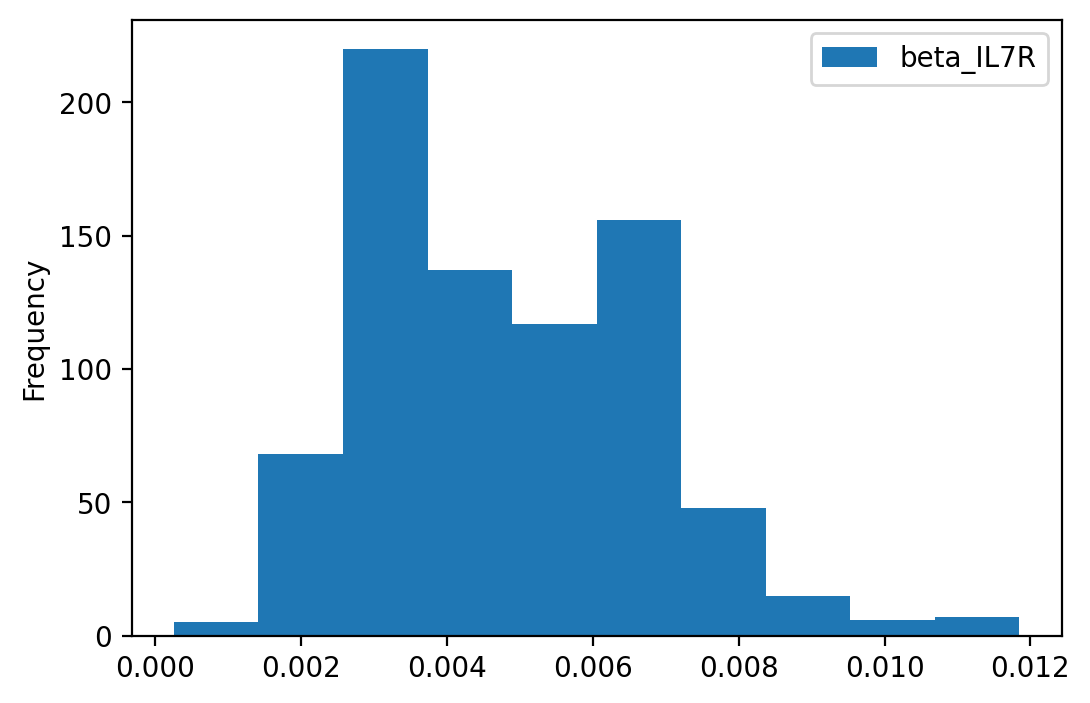

In [50]:
plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 100
df.join(gf.adata.obs.cell_type).query('cell_type == "T_CD4"')[['beta_IL7R']].plot.hist()
plt.show()

In [62]:
(pd.read_parquet('/Volumes/SSD/genome_screens/human_tonsil/IL7_4n_0x.parquet')-adata.layers[
    'imputed_count']).join(
    adata.obs.cell_type
).groupby('cell_type').mean().mean(1).sort_values(ascending=False, key=abs)

cell_type
T_CD4                 -0.000849
FDC                   -0.000478
NK                    -0.000377
T_follicular_helper   -0.000292
B_memory              -0.000256
mDC                   -0.000203
myeloid               -0.000202
B_germinal_center     -0.000192
T_CD8                 -0.000158
pDC                   -0.000101
plasma                -0.000087
T_double_neg          -0.000081
B_naive                0.000019
dtype: float64

In [61]:
(pd.read_parquet('/Volumes/SSD/genome_screens/human_tonsil/IL7R_4n_0x.parquet')-adata.layers[
    'imputed_count']).join(
    adata.obs.cell_type
).groupby('cell_type').mean().mean(1).sort_values(ascending=False, key=abs)

cell_type
T_CD4                 -0.001154
NK                    -0.000544
T_CD8                 -0.000309
mDC                   -0.000305
myeloid               -0.000223
FDC                   -0.000175
T_follicular_helper   -0.000134
T_double_neg          -0.000105
pDC                   -0.000094
plasma                -0.000014
B_naive               -0.000011
B_memory              -0.000011
B_germinal_center     -0.000005
dtype: float64

In [46]:
df.join(gf.adata.obs.cell_type).query('cell_type == "T_CD4"').drop(
    columns=['cell_type']).mean().sort_values(
    ascending=False, key=abs).head(10)

beta_ZNF219    -0.986513
beta_TEAD2     -0.903023
beta_IL7        0.748095
beta_LGALS9     0.560340
beta_EGR1      -0.491040
beta_RFX8       0.457854
beta_FOXP3      0.379840
beta_ANGPTL1    0.357991
beta_BCL6       0.327434
beta_ANGPT2     0.256969
dtype: float64

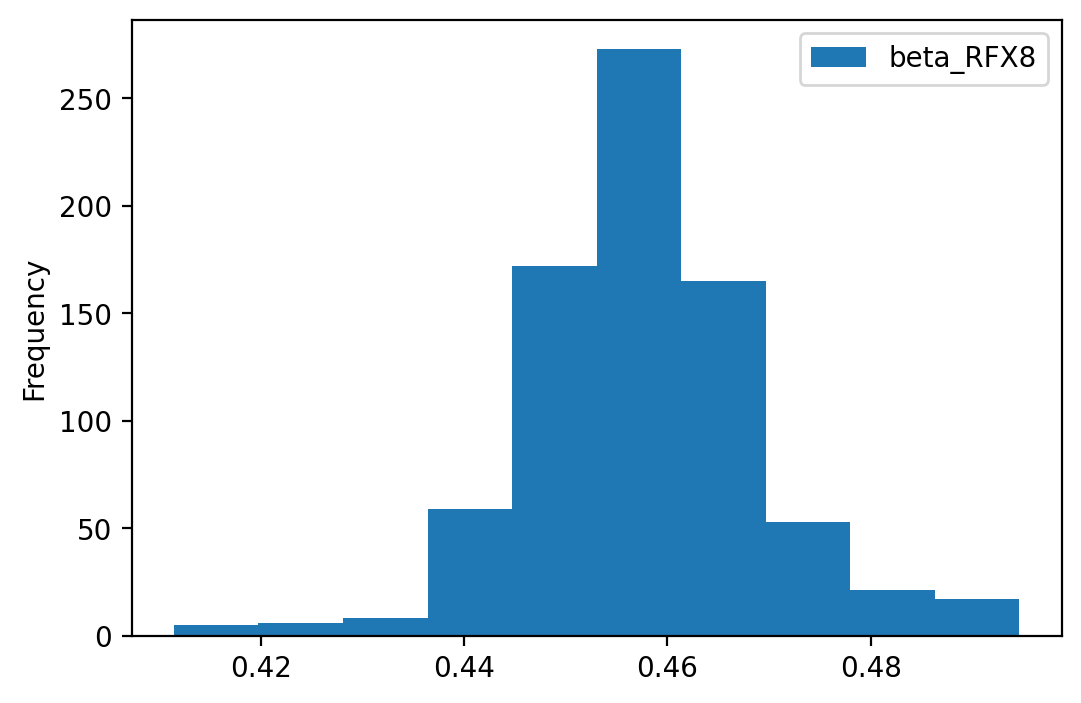

In [40]:
plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 100
df.join(gf.adata.obs.cell_type).query('cell_type == "T_CD4"')[['beta_RFX8']].plot.hist()
plt.show()